In [1]:
from IPython import display
from ultralytics import YOLO
display.clear_output()

Generated test equation: 86-82
Generated test equation: 44*34
Generated test equation: 32*87
Generated test equation: 19*69
Generated test equation: 52-16
Generated test equation: 52+48
Generated test equation: 38*62
Generated test equation: 33-2
Generated test equation: 35-38
Generated test equation: 97*23
Generated test equation: 73-10
Generated test equation: 51*81
Generated test equation: 33*21
Generated test equation: 23+6
Generated test equation: 51*93
Generated test equation: 77+29
Generated test equation: 20-72
Generated test equation: 94*42
Generated test equation: 61-60
Generated test equation: 76-38
Generated test equation: 96*19
Generated test equation: 65-29
Generated test equation: 99-76
Generated test equation: 95-11
Generated test equation: 77-33
Generated test equation: 97+53
Generated test equation: 44*42
Generated test equation: 16+41
Generated test equation: 94*32
Generated test equation: 18*64
Generated test equation: 44*68
Generated test equation: 27-71
Generated 

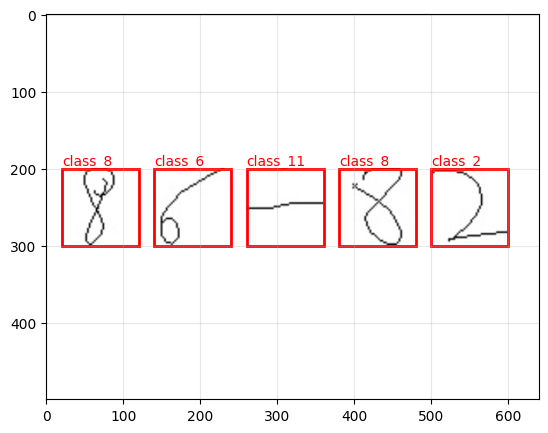

In [2]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from skimage import io
import json
import cv2

# Set up parameters
folder = "../data/"  # Your source data folder
output_folder = "yolo_equation_images"  # Where to save generated equations
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


def equation_generator(numbers=2, max_num=100):
    assert numbers > 1, "You need at least two numbers to generate a valid equation"
    # Generate numbers and operator
    generated_eqn = []
    operators = ['+', '-', '*']
    for number in range(numbers):
        gen_num = np.random.randint(max_num)
        generated_eqn.append(str(gen_num))
        if number < numbers - 1:  # Add an operator only between numbers
            operator_ind = np.random.randint(len(operators))
            operator = operators[operator_ind]
            generated_eqn.append(operator)
    # Turn into string without calculating the result
    generated_eqn = ''.join(generated_eqn)
    return generated_eqn

def random_sample_file(directory):
    #  Randomly selects a file from a directory
    n=0
    random.seed();
    for root, dirs, files in os.walk(directory):
        for name in files:
            n += 1
            if random.uniform(0, n) < 1:
                rfile=os.path.join(root, name)
    return rfile


# Parameters for equation generation
EQNS = 100  # Number of test equations to generate
NUMBERS = 2  # Number of numbers in each equation
MAX_NUM = 100  # Max value for random numbers

def generate_eqn_image_with_yolo_labels(folder, eqn):
    eqn_array = []
    yolo_boxes = []  # Will store [class_id, x_center, y_center, width, height]
    current_x = 20
    
    # Create fixed canvas size
    canvas_height = 500
    canvas_width = None  # Will be set after calculating full width
    char_spacing = 20
    
    # Map characters to class IDs
    class_mapping = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        '+': 10, '-': 11, '*': 12, 'times': 12
    }
    
    # First pass to calculate total width
    total_width = 20  # Initial padding
    for char in eqn:
        total_width += 100 + char_spacing  # char_width + spacing
    total_width += 20  # Final padding
    canvas_width = total_width
    
    # Create blank canvas
    canvas = np.ones((canvas_height, canvas_width)) * 255
    
    # Place characters and calculate YOLO format boxes
    current_x = 20
    for char in eqn:
        orig_char = char
        if char == "*": char = 'times'
        char_folder = f"{folder}/{char}"
        file = random_sample_file(char_folder)
        img = io.imread(file)
        
        char_width = 100
        char_height = 100
        y_start = 200
        
        # Convert to correct format and resize
        if len(img.shape) == 3:  # If image is RGB
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_resized = cv2.resize(img, (char_width, char_height))
        
        # Place the resized image on canvas
        canvas[y_start:y_start+char_height, current_x:current_x+char_width] = img_resized
        
        # Calculate YOLO format boxes
        x_center = (current_x + char_width/2) / canvas_width
        y_center = (y_start + char_height/2) / canvas_height
        norm_width = char_width / canvas_width
        norm_height = char_height / canvas_height
        
        class_id = class_mapping[orig_char]
        yolo_boxes.append([class_id, x_center, y_center, norm_width, norm_height])
        
        current_x += char_width + char_spacing
    
    return canvas, yolo_boxes

# Modified generation loop
output_folder = "yolo_equation_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for i in range(EQNS):
    eqn = equation_generator(numbers=NUMBERS, max_num=MAX_NUM)
    print(f"Generated test equation: {eqn}")
    
    # Generate image and get YOLO format boxes
    eqn_array, yolo_boxes = generate_eqn_image_with_yolo_labels(folder, eqn)
    filename = f"{NUMBERS}numbers_test_{str(i).zfill(3)}"
    
    # Save image
    cv2.imwrite(os.path.join(output_folder, f"{filename}.png"), eqn_array)
    
    # Save YOLO format labels (one line per box: class_id x_center y_center width height)
    with open(os.path.join(output_folder, f"{filename}.txt"), 'w') as f:
        for box in yolo_boxes:
            f.write(f"{box[0]} {box[1]:.6f} {box[2]:.6f} {box[3]:.6f} {box[4]:.6f}\n")

# Visualization function to verify YOLO format boxes
def visualize_yolo_labels(image_path, label_path):
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    
    plt.figure(figsize=(15, 5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x_center, y_center, w, h = map(float, line.strip().split())
            
            # Convert normalized coordinates back to pixel values
            x_center *= width
            y_center *= height
            w *= width
            h *= height
            
            # Calculate box corners
            x1 = int(x_center - w/2)
            y1 = int(y_center - h/2)
            
            # Draw rectangle
            rect = plt.Rectangle((x1, y1), w, h, fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            plt.text(x1, y1-5, f'class_{int(class_id)}', color='red')
    
    plt.axis('on')
    plt.grid(True, alpha=0.3)
    plt.show()

# Verify first generated image
first_image = os.path.join(output_folder, "2numbers_test_000.png")
first_label = os.path.join(output_folder, "2numbers_test_000.txt")
visualize_yolo_labels(first_image, first_label)

In [ ]:
import yaml
# 1. First, create a YAML file for your dataset
def create_yaml():
    yaml_content = {
        'train': os.path.abspath('yolo_equation_images'),  # Path to training images
        'val': os.path.abspath('yolo_equation_images'),    # Using same for validation
        'nc': 13,  # Number of classes (0-9 plus +,-,*)
        'names': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '*']  # Class names
    }
    
    with open('dataset.yaml', 'w') as f:
        yaml.dump(yaml_content, f)

create_yaml()

# 2. Train the model
model = YOLO('yolov8n.pt')  # Load YOLOv8 nano model
results = model.train(
    data='dataset.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='equation_detection'
)

# 3. Function to run inference and display results
def detect_and_display(model, image_path):
    # Run inference
    results = model.predict(image_path, conf=0.25)  # Adjust confidence threshold as needed
    
    # Load and display image with predictions
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 10))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot image with detections
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    
    # Get results
    boxes = results[0].boxes
    
    # Draw boxes and labels
    for box in boxes:
        # Get box coordinates
        x1, y1, x2, y2 = box.xyxy[0]
        class_id = int(box.cls[0])
        conf = float(box.conf[0])
        
        # Convert tensor to numpy
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Draw rectangle
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        
        # Add label
        class_name = model.names[class_id]
        plt.text(x1, y1-10, f'{class_name} {conf:.2f}', 
                color='red', fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.7))
    
    plt.title('Detected Objects')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 4. Test on a single image
test_image_path = 'yolo_equation_images/2numbers_test_000.png'
detect_and_display(model, test_image_path)

# 5. Optional: Test on multiple images
def test_multiple_images(model, test_folder, num_images=5):
    image_files = [f for f in os.listdir(test_folder) if f.endswith('.png')]
    for image_file in random.sample(image_files, min(num_images, len(image_files))):
        image_path = os.path.join(test_folder, image_file)
        print(f"\nTesting image: {image_file}")
        detect_and_display(model, image_path)

# Test on multiple images
test_multiple_images(model, 'yolo_equation_images')

New https://pypi.org/project/ultralytics/8.3.39 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.35 🚀 Python-3.11.9 torch-2.4.0+cu121 CPU (AMD EPYC 7H12 64-Core Processor)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=equation_detection2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

train: Scanning /home/ayyildi1/CMSE492Project/cmse492_project/notebooks/yolo_equation_images... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 1567.89it/s]

train: New cache created: /home/ayyildi1/CMSE492Project/cmse492_project/notebooks/yolo_equation_images.cache



val: Scanning /home/ayyildi1/CMSE492Project/cmse492_project/notebooks/yolo_equation_images.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/detect/equation_detection2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/equation_detection2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.105      4.241      1.739         40        640: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        100        478     0.0263      0.443     0.0314      0.016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.855       4.13       1.49        143        640:  14%|█▍        | 1/7 [00:02<00:13,  2.27s/it]